# Histopathologic Cancer Classification

In this project, I train a convolutional neural network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. The Kaggle page for this project can be found at https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview.

The project data consists of RGB TIF images. There are 220,025 training images and 57,458 test images. The training images all have ground truth classifications that are saved in a csv file that is provided in the Kaggle competition page. The raw data is not included in this repository.

## Loading libraries and data

For this project, I chose to use the PyTorch module to build and train my CNN. I have done some projects with PyTorch in the past and I'm more familiar with its use than I am with Keras or TensorFlow. Because the data is several gigabytes, I don't actually load it all into memory at once. This following cell simply loads the training data ground truth labels document and sets my computer's GPU as the training device. I have CUDA all set up, so training on my GPU will be much faster than my CPU.

In [19]:
import torch                # I have not used keras much before. I'm more familiar with pytorch so I'll use that
import torch.nn as nn
import torch.nn.functional as F
import tifffile as tiff     # For reading in the .tif images
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Want to make sure I'm training on my GPU because I do not have one million years to train on my CPU
torch.set_default_device('cuda')
print(torch.cuda.get_device_name(0))

train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

NVIDIA GeForce RTX 3090


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## EDA

In this section, I take a look through the data just to make sure everything is as I expect. The data provided by Kaggle are very clean and consistent already, so no cleaning should be particularly necessary. In the following cell, I take a look at the positive/negative class imbalance, check that I can read images correctly with the tifffile module, check for any files not matching expected format (in a subsample of the training dataset), and check for any channel bias across the RGB channels.

There is some slight class imbalance with ~59.5% negative and ~40.5% positive. This imbalance isn't so skewed that I expect it to cause significant bias towards positive or negative predictions, so I leave it as is. I ran my random sampling a few times and did not find any badly formatted files, thus I did not have any samples to exclude. Lastly, my color channel bias analysis showed a slightly lower average intensity in the green channel, but there was enough deviation across the three color channels that there was no clear need for channel normalization. Perhaps a normalizing transform could be a next step for model improvement, but the data should be fine as is for training an initial model.

label
0    130908
1     89117
Name: count, dtype: int64
Found 0 duplicated file IDs


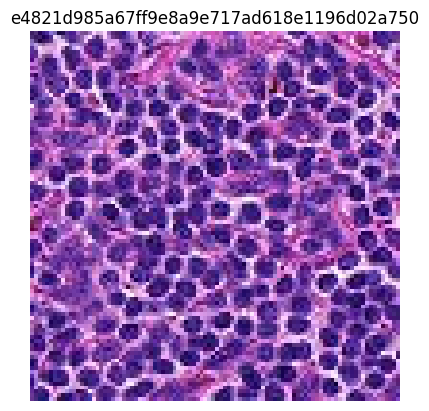

Found 0 images not matching format expectations
Mean per channel: [179.47335525 139.5495765  177.51256402]
Std per channel: [46.35405467 51.52928408 42.3398958 ]


In [2]:
# Checking for class imbalance in training data labels
print(train_labels['label'].value_counts())
duplicate_ids = train_labels.duplicated(subset='id').sum()
print(f'Found {duplicate_ids} duplicated file IDs')

def read_image(image_id: str):
    path = os.path.join('train', f'{image_id}.tif')
    img = tiff.imread(path)
    return img

# Test image reading
def show_image(image_id: str) -> None:
    img = read_image(image_id)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_id)
    plt.show()

sample_images = train_labels.sample(n=1000)

show_image(sample_images.iloc[100]['id'])

# Check for corrupt or files not matching expectations
bad_files = []
for image_id in sample_images['id']:
    try:
        img = read_image(image_id)
        assert img.shape == (96, 96, 3)
    except Exception as e:
        print(f'image {image_id} does not match format expectations.')
        bad_files.append(image_id)

print(f'Found {len(bad_files)} images not matching format expectations')

# Check for color channel bias
means = []
stds = []

for image_id in sample_images['id']:
    img = read_image(image_id)
    means.append(np.mean(img, axis=(0, 1)))
    stds.append(np.std(img, axis=(0, 1)))

mean = np.mean(means, axis=0)
std = np.mean(stds, axis=0)
print('Mean per channel:', mean)
print('Std per channel:', std)


## Model building

As a recap, this CNN is built to classify 96x96 RGB images. At a high level, the model follow a standard deep-convolutional pipeline with batch normalization and PReLU regularization. The convolutional layers are followed by Global Average Pooling and a fully connected classifier. The architecture can be summarized by:
```
[Conv -> Batch Normalization -> PReLU Regularization -> Batch Normalization -> PReLU Regularization -> MaxPool] x 4
-> Global Average Pooling
-> Fully Connected Classifier
```

#### Convolutional Blocks:
Each of the four convolutional blocks consists of:
- Two 3x3 convolutional layers with padding=1 to preserve spatial resolution
- Batch Normalization after each convolution to stabilize training by normalizing intermediate feature maps. This *should* speed up training and be more robust against weight initialization
- PReLU activation instead of typical ReLU. This means it has a learnable slope for negative inputs allowing the network to learn optimal activation behaviour dynamically
- MaxPooling with 2x2 kernels to halve the spatial resolution after each block which will reduce feature map size by 2x

The filter counts progress across the four blocks by 32 -> 64 -> 128 -> 256. This is done to increase the model's representational capacity as spatial dimensions shrink.

#### Global Averaging Pooling
After the convolutional blocks, the GAP layer (`nn.AdaptiveAvgPool2d(1)`) reduces each feature map to a single scalar by averaging across spatial dimensions. This greatly reduces the number of parameters from the full 6x6x256 to 1x1x256. This is done to lower the risk of overfitting and act as a transition to the dense layers of the classifier.

#### Fully Connected Classifier
The classifier consists of:
- A linear layer (256 -> 128), again with PReLU activation
- A dropout layer (p=0.5) to reduce overfitting risk by randomly zeroing activations during training
- A final linear layer (128 -> 2) to output the two target classes (positive or negative tumor presence)

As a note for later, using `CrossEntropyLoss` later on in the trainer applies SoftMax automatically so I don't explicitly include it in the final layer even though this is a classification model.

#### Summary
- The `[Conv -> BN -> PReLU]` x2 pattern is pretty typical for deep feature learning and stable gradient flow.
- Using four convolutional blocks allows the model to develop high-level semantic representations while reducing spatial resolution. I could use more blocks but I stuck with four for the sake of training time and model complexity.
- The GAP and Dropout help keep the classifier's dense layers a bit more lightweight and hopefully less prone to overfitting.

In [ ]:
class CancerClassifierCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CancerClassifierCNN, self).__init__()

        # define [conv, conv, pool] block structure
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.PReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.PReLU(),
                nn.MaxPool2d(kernel_size=2)
            )

        self.block1 = conv_block(3, 32)     # output: (32, 48, 48)
        self.block2 = conv_block(32, 64)    # output: (64, 24, 24)
        self.block3 = conv_block(64, 128)   # output: (128, 12, 12)
        self.block4 = conv_block(128, 256)  # output: (256, 6, 6)

        self.gap = nn.AdaptiveAvgPool2d(1)  # output: (256, 1, 1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                 
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = self.classifier(x)

        return x
    
model = CancerClassifierCNN()
next(model.parameters()).device # Double check that it's using my GPU

device(type='cuda', index=0)

## Building a Data Loader (kinda preprocessing, more just getting ducks in order)
The purpose of building a data loader is to more efficiently handle a 220k image dataset. I don't want to keep 6GB of images in memory, so I use the PyTorch Dataset class that can perform on-the-fly loading of images and associated labels. You can see the class HistopathologyDataset class I make extends Dataset so its purpose is to enable loading of training data as needed in the training process.

The basic function looks up the image_id (name of the image file) and corresponding label from the input dataframe (loaded from train_labels.csv later on). It loads the image itself using the tifffile library as I did earlier in my EDA. It converts the numpy array representation of the image to a PIL Image object which is needed to apply PyTorch image transformations. It then applies a given transform to convert the image to a PyTorch tensor.

As I mentioned earlier, you can see that I don't actually use a fancy transformation, just a simple conversion to tensor using `basic_transform = transforms.ToTensor()` which is passed into the dataset objects. This is a potential area for improvement in future model iterations. Beyond that, I define two datasets for training and validation from the full training dataset. I use a 90/10 train/validate split. The data loader I define after that is responsible for batching, shuffling, and parallel loading of data for training.

In [14]:
# Build a data loader so I'm not stuck with 6GB of training images in memory
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split

class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]['id']
        label = self.dataframe.iloc[idx]['label']

        image_path = os.path.join(self.image_dir, f'{image_id}.tif')
        image = tiff.imread(image_path)

        # Convert NumPy array to PIL Image so transforms can be applied
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

train_df, val_df = train_test_split(train_labels, stratify=train_labels['label'], test_size=0.1)

basic_transform = transforms.ToTensor()

train_dataset = HistopathologyDataset(train_df, image_dir='train', transform=basic_transform)
val_dataset = HistopathologyDataset(val_df, image_dir='train', transform=basic_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, generator=torch.Generator(device='cuda'))

## Model Training
The following block is where I train the model and do some logging of salient metrics such as learning rate, train/validate set loss, and train/validate set accuracy. I use tensorboard for logging which is a handy tool that creates some plots for you that I include in the next section.

As I described in the model building section, the `criterion = nn.CrossEntropyLoss()` is used for classification with SoftMax internally applied. The Adam optimizer is chosen for its adaptive learning rates and strong convergence properties because that's what Google tells me. This is another potential area for improvement because I don't fully understand how the choice of optimizer affects gradient descent of my model. The `weight_decay` parameter is used to prevent overfitting by penalizing larger weights.

The `train_one_epoch` function is used to train an epoch. It sets the model to training mode, iterates through batches using the data loaders, and tracks cumulative loss and classification accuracy across the full dataset.

The `validate` function has the same structure as training, but it sets the model to evaluation mode to disable dropout and batch normalization updates. It returns the final validation loss and accuracy.

I use 15 epochs in my training because that took about an hour to chug through and that's about as long as I was willing to wait while still allowing for pretty good convergence. The scheduler I define monitors validation loss and dynamically drops learning rate by 50% if it stops improving for 2 consecutive epochs. This should help find minima during gradient descent to avoid plateauing.

Otherwise I just have some printouts and tracking and a little checkpoint to save the best performing model by validation accuracy. My training loop logs the metrics I discussed earlier using tensorboard.

In [ ]:
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

writer = SummaryWriter(log_dir='runs/experiment_2')
dummy_input = torch.randn(1, 3, 96, 96).to('cuda')
writer.add_graph(model, dummy_input)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc='Training'):
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

num_epochs = 15
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{num_epochs} \n'
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}\n'
          f'Val Loss: {val_loss:.4f}     | Val Acc: {val_acc:.4f}')
    
    # TensorBoard logging
    lr = get_lr(optimizer)
    writer.add_scalar('LearningRate', lr, epoch)
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_acc, epoch)
    writer.add_scalar('Accuracy/Val', val_acc, epoch)

writer.close()

Training: 100%|██████████| 3095/3095 [03:04<00:00, 16.78it/s]


Epoch 1/15 | 
Train Loss: 0.2918 | Train Acc: 0.8806 | 
Val Loss: 0.2441 | Val Acc: 0.8988


Training: 100%|██████████| 3095/3095 [03:03<00:00, 16.86it/s]


Epoch 2/15 | 
Train Loss: 0.1872 | Train Acc: 0.9300 | 
Val Loss: 0.2407 | Val Acc: 0.9006


Training: 100%|██████████| 3095/3095 [03:02<00:00, 16.92it/s]


Epoch 3/15 | 
Train Loss: 0.1545 | Train Acc: 0.9444 | 
Val Loss: 0.3438 | Val Acc: 0.8805


Training: 100%|██████████| 3095/3095 [03:03<00:00, 16.84it/s]


Epoch 4/15 | 
Train Loss: 0.1327 | Train Acc: 0.9524 | 
Val Loss: 0.2340 | Val Acc: 0.9160


Training: 100%|██████████| 3095/3095 [03:25<00:00, 15.06it/s]


Epoch 5/15 | 
Train Loss: 0.1191 | Train Acc: 0.9583 | 
Val Loss: 0.1804 | Val Acc: 0.9317


Training: 100%|██████████| 3095/3095 [03:29<00:00, 14.76it/s]


Epoch 6/15 | 
Train Loss: 0.1079 | Train Acc: 0.9626 | 
Val Loss: 0.2090 | Val Acc: 0.9372


Training: 100%|██████████| 3095/3095 [03:30<00:00, 14.68it/s]


Epoch 7/15 | 
Train Loss: 0.0983 | Train Acc: 0.9658 | 
Val Loss: 0.1390 | Val Acc: 0.9519


Training: 100%|██████████| 3095/3095 [03:22<00:00, 15.30it/s]


Epoch 8/15 | 
Train Loss: 0.0890 | Train Acc: 0.9693 | 
Val Loss: 0.1254 | Val Acc: 0.9558


Training: 100%|██████████| 3095/3095 [03:21<00:00, 15.34it/s]


Epoch 9/15 | 
Train Loss: 0.0811 | Train Acc: 0.9722 | 
Val Loss: 0.2982 | Val Acc: 0.9103


Training: 100%|██████████| 3095/3095 [03:19<00:00, 15.52it/s]


Epoch 10/15 | 
Train Loss: 0.0740 | Train Acc: 0.9747 | 
Val Loss: 0.1323 | Val Acc: 0.9505


Training: 100%|██████████| 3095/3095 [03:02<00:00, 16.94it/s]


Epoch 11/15 | 
Train Loss: 0.0676 | Train Acc: 0.9764 | 
Val Loss: 0.1413 | Val Acc: 0.9566


Training: 100%|██████████| 3095/3095 [03:02<00:00, 16.94it/s]


Epoch 12/15 | 
Train Loss: 0.0433 | Train Acc: 0.9856 | 
Val Loss: 0.1166 | Val Acc: 0.9642


Training: 100%|██████████| 3095/3095 [03:04<00:00, 16.75it/s]


Epoch 13/15 | 
Train Loss: 0.0340 | Train Acc: 0.9884 | 
Val Loss: 0.1712 | Val Acc: 0.9459


Training: 100%|██████████| 3095/3095 [03:05<00:00, 16.72it/s]


Epoch 14/15 | 
Train Loss: 0.0304 | Train Acc: 0.9897 | 
Val Loss: 0.1213 | Val Acc: 0.9676


Training: 100%|██████████| 3095/3095 [03:04<00:00, 16.79it/s]


Epoch 15/15 | 
Train Loss: 0.0274 | Train Acc: 0.9907 | 
Val Loss: 0.1575 | Val Acc: 0.9597


## Training Evaluation
Below is a screenshot of my model's training progression as it progressed through the 15 epochs. You can see it converges pretty steadily, but maybe has some room for improvement.

Training accuracy started pretty high around 88% and increased somewhat logarithmically up to ~99%. Validation accuracy did also increase across epochs, but it was much less steady from around 90% up to 96%. The misalignment between validation and training accuracy suggest a slight degree of overfitting, but the overall high accuracy is pretty indicative of a well fit model. This is mirrored in the ostensibly exponential decay of loss in the training data and bouncy but observable decrease in loss on the validation data.

The learning rate did drop off towards the later epochs which means my model did indeed converge to the point where it needed more granular learning.

In summary, it looks like my model did a good job converging and and pretty good accuracy with the training data. It might have converged a bit more with another 5 epochs, but I think the performance I got was pretty well suited to the training time of about 50 minutes.
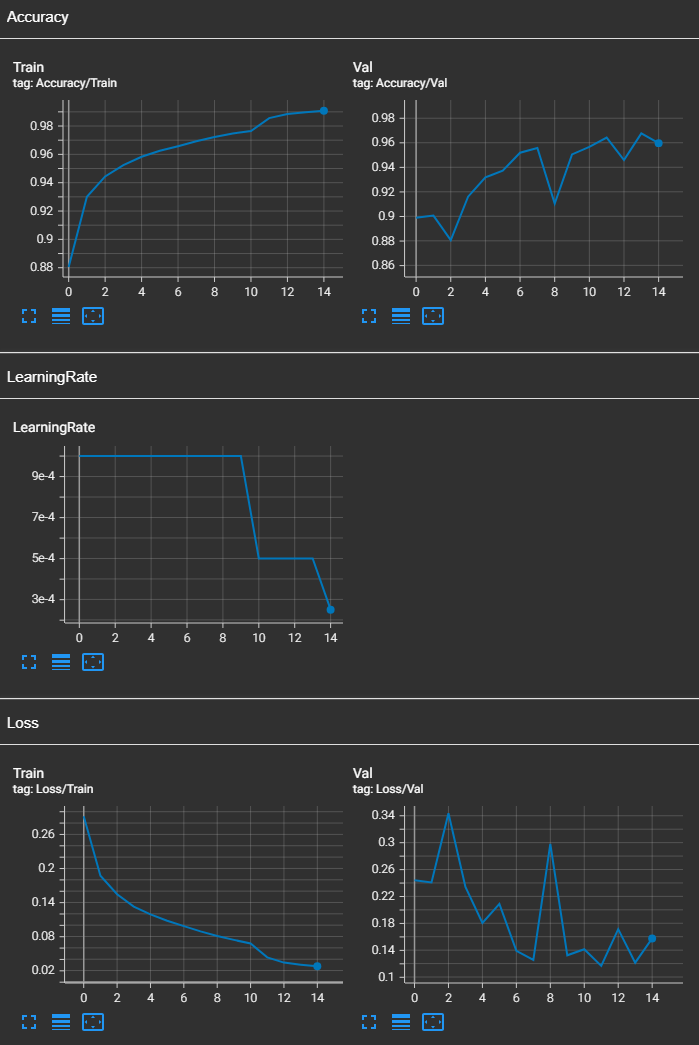

## Running test data
The below cell is just used to actually run the model on all of the test image data. The final output is a CSV where each image ID is assigned a float probability between 0 and 1 of the image containing a tumor in the center 32x32 pixel area. It puts the test data into a dataset class as I defined and uses a data loader as I described earlier as well.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        path = os.path.join(self.image_dir, f'{image_id}.tif')
        image = tiff.imread(path)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image_id, image
    
test_dataset = TestDataset(image_dir='test', transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, generator=torch.Generator(device='cuda'))

model.eval()
submission = []

with torch.no_grad():
    for image_ids, images in tqdm(test_loader, desc='Evaluating'):
        images = images.to('cuda')
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get probability of class 1 (tumor)
        for img_id, prob in zip(image_ids, probs.cpu().numpy()):
            submission.append((img_id, prob))

Evaluating: 100%|██████████| 898/898 [00:31<00:00, 28.89it/s]


In [17]:
submission_df = pd.DataFrame(submission, columns=['id', 'label'])
submission_df.to_csv('submission.csv', index=False, float_format='%.6f')

## Final Results!
The final total score for my model (the Private Score) was about 92%. That means that I correctly classified about 92% of the images in the test dataset. This is a pretty good score for a model that was not tuned particularly well.

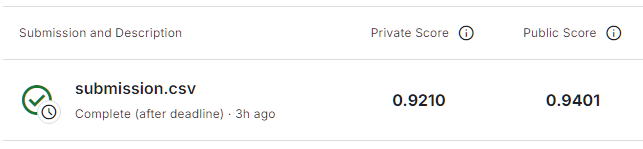